##### Copyright 2022 The TensorFlow Authors.

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.9.1


In [2]:
dataset = pd.read_csv('../data/bank/bank-full.csv', sep=';')


In [3]:
dataset.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [4]:
dataset.month = dataset.month.map({"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5,
                                  "jun": 6, "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12})

dataset.default = dataset.default.map({'no': 0, 'yes': 1})
dataset.housing = dataset.housing.map({'no': 0, 'yes': 1})
dataset.loan = dataset.loan.map({'no': 0, 'yes': 1})
dataset.y = dataset.y.map({'no': 0, 'yes': 1})


In [5]:
X = dataset[['duration', 'poutcome', 'month', 'pdays', 'age', 'balance', 'housing', 'day', 'contact']]
X = pd.get_dummies(X)

y = dataset.y



Split the dataset into training and test sets using [`pandas.DataFrame.sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html){:.external}, [`pandas.DataFrame.drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html){:.external} and [`pandas.DataFrame.iloc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html){:.external}. Make sure to split the features from the target labels. The test set is used to evaluate your model's generalizability to unseen data.

In [8]:
x_train = X.sample(frac=0.75, random_state=1)
y_train = y.sample(frac=0.75, random_state=1)
# print(len(x_train))
# print(len(y_train))


In [9]:
x_test = X.drop(x_train.index)
y_test = y.drop(y_train.index)
# print(len(x_test))
# print(len(y_test))


## Preprocess the data

This dataset contains the mean, standard error, and largest values for each of the 10 tumor measurements collected per example. The `"diagnosis"` target column is a categorical variable with `'M'` indicating a malignant tumor and `'B'` indicating a benign tumor diagnosis. This column needs to be converted into a numerical binary format for model training.

The [`pandas.Series.map`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html){:.external} function is useful for mapping binary values to the categories.

The dataset should also be converted to a tensor with the `tf.convert_to_tensor` function after the preprocessing is complete.

In [10]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
# print(y_train)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)


3610     0
11677    0
33018    0
44323    1
8119     0
        ..
24621    0
5791     0
27598    0
21461    0
11572    0
Name: y, Length: 33908, dtype: int64


## Logistic regression

Before building a logistic regression model, it is crucial to understand the method's differences compared to traditional linear regression.

### Logistic regression fundamentals

Linear regression returns a linear combination of its inputs; this output is unbounded. The output of a [logistic regression](https://developers.google.com/machine-learning/glossary#logistic_regression){:.external} is in the `(0, 1)` range. For each example, it represents the probability that the example belongs to the _positive_ class.

Logistic regression maps the continuous outputs of traditional linear regression, `(-∞, ∞)`, to probabilities, `(0, 1)`. This transformation is also symmetric so that flipping the sign of the linear output results in the inverse of the original probability.

Let $Y$ denote the probability of being in class `1` (the tumor is malignant). The desired mapping can be achieved by interpreting the linear regression output as the [log odds](https://developers.google.com/machine-learning/glossary#log-odds){:.external} ratio of being in class `1` as opposed to class `0`:

$$\ln(\frac{Y}{1-Y}) = wX + b$$

By setting $wX + b = z$, this equation can then be solved for $Y$:

$$Y = \frac{e^{z}}{1 + e^{z}} = \frac{1}{1 + e^{-z}}$$

The expression $\frac{1}{1 + e^{-z}}$ is known as the [sigmoid function](https://developers.google.com/machine-learning/glossary#sigmoid_function){:.external} $\sigma(z)$. Hence, the equation for logistic regression can be written as $Y = \sigma(wX + b)$.

The dataset in this tutorial deals with a high-dimensional feature matrix. Therefore, the above equation must be rewritten in a matrix vector form as follows:

$${\mathrm{Y}} = \sigma({\mathrm{X}}w + b)$$

where:

* $\underset{m\times 1}{\mathrm{Y}}$: a target vector
* $\underset{m\times n}{\mathrm{X}}$: a feature matrix
* $\underset{n\times 1}w$: a weight vector
* $b$: a bias
* $\sigma$: a sigmoid function applied to each element of the output vector

Start by visualizing the sigmoid function, which transforms the linear output, `(-∞, ∞)`, to fall between `0` and `1`. The sigmoid function is available in `tf.math.sigmoid`.

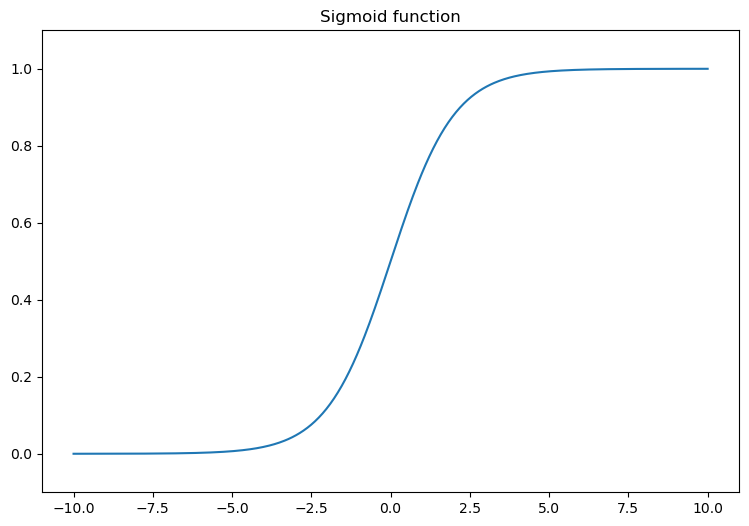

In [12]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");

plt.show(sns)


### The log loss function

The  [log loss](https://developers.google.com/machine-learning/glossary#Log_Loss){:.external}, or binary cross-entropy loss, is the ideal loss function for a binary classification problem with logistic regression. For each example, the log loss quantifies the similarity between a predicted probability and the example's true value. It is determined by the following equation:

$$L = -\frac{1}{m}\sum_{i=1}^{m}y_i\cdot\log(\hat{y}_i) + (1- y_i)\cdot\log(1 - \hat{y}_i)$$

where:

* $\hat{y}$: a vector of predicted probabilities
* $y$: a vector of true targets

You can use the `tf.nn.sigmoid_cross_entropy_with_logits` function to compute the log loss. This function automatically applies the sigmoid activation to the regression output:

In [13]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

### The gradient descent update rule

The TensorFlow Core APIs support automatic differentiation with `tf.GradientTape`. If you are curious about the mathematics behind the logistic regression [gradient updates](https://developers.google.com/machine-learning/glossary#gradient_descent){:.external}, here is a short explanation:

In the above equation for the log loss, recall that each $\hat{y}_i$ can be rewritten in terms of the inputs as $\sigma({\mathrm{X_i}}w + b)$.

The goal is to find a $w^*$ and $b^*$ that minimize the log loss:

$$L = -\frac{1}{m}\sum_{i=1}^{m}y_i\cdot\log(\sigma({\mathrm{X_i}}w + b)) + (1- y_i)\cdot\log(1 - \sigma({\mathrm{X_i}}w + b))$$

By taking the gradient $L$ with respect to $w$, you get the following:

$$\frac{\partial L}{\partial w} = \frac{1}{m}(\sigma({\mathrm{X}}w + b) - y)X$$

By taking the gradient $L$ with respect to $b$, you get the following:

$$\frac{\partial L}{\partial b} = \frac{1}{m}\sum_{i=1}^{m}\sigma({\mathrm{X_i}}w + b) - y_i$$

Now, build the logistic regression model.

In [14]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False
    
  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

To validate, make sure the untrained model outputs values in the range of `(0, 1)` for a small subset of the training data.

In [15]:
log_reg = LogisticRegression()

In [16]:
y_pred = log_reg(x_train[:100], train=False)
y_pred.numpy()

array([1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 9.9926615e-01, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 0.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.9494235e-05, 0.0000000e+00, 1.0000000e+00, 1.0000000e

Next, write an accuracy function to calculate the proportion of correct classifications during training. In order to retrieve the classifications from the predicted probabilities, set a threshold for which all probabilities higher than the threshold belong to class `1`. This is a configurable hyperparameter that can be set to `0.5` as a default.

In [17]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

### Train the model

Using mini-batches for training provides both memory efficiency and faster convergence. The `tf.data.Dataset` API has useful functions for batching and shuffling. The API enables you to build complex input pipelines from simple, reusable pieces. 

In [18]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

Now write a training loop for the logistic regression model. The loop utilizes the log loss function and its gradients with respect to the input in order to iteratively update the model's parameters.

In [21]:
# Set training parameters
epochs = 200
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 1389.228
Epoch: 20, Training log loss: 1110.274
Epoch: 40, Training log loss: 1274.323
Epoch: 60, Training log loss: 1308.909
Epoch: 80, Training log loss: 1214.815
Epoch: 100, Training log loss: 1251.908
Epoch: 120, Training log loss: 1209.266
Epoch: 140, Training log loss: 1189.386
Epoch: 160, Training log loss: 1180.377
Epoch: 180, Training log loss: 1283.230


### Performance evaluation

Observe the changes in your model's loss and accuracy over time. 

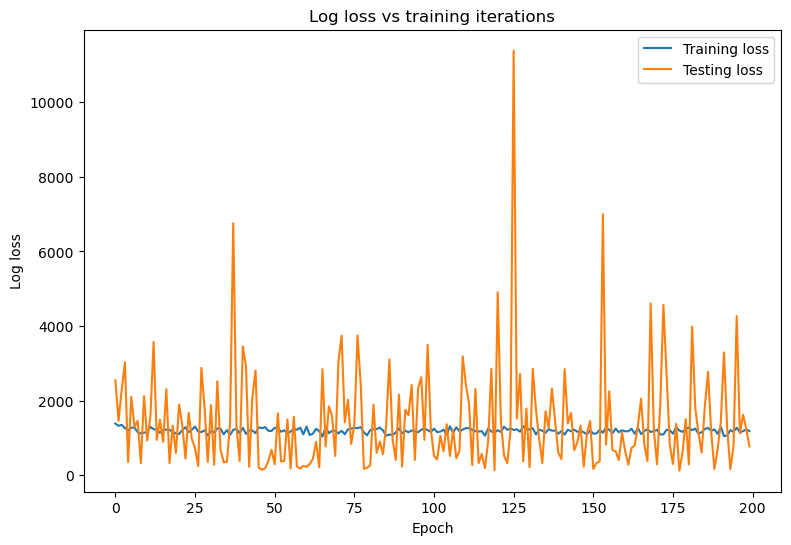

In [22]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

plt.show(sns)


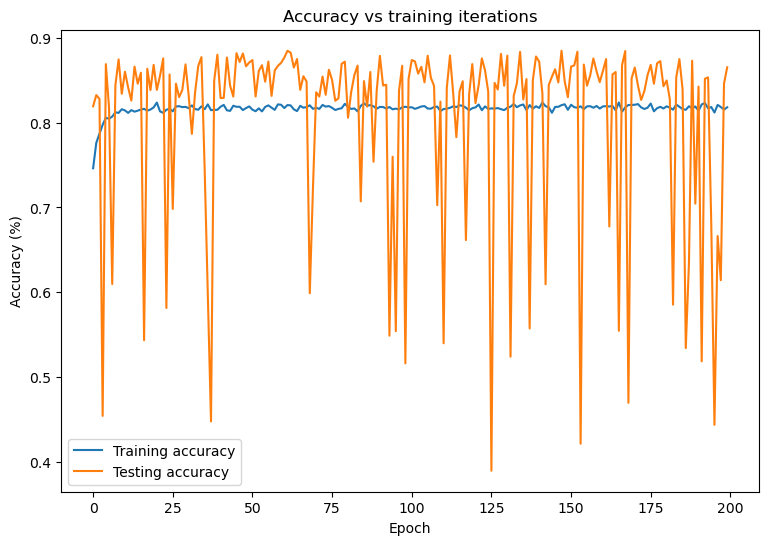

In [23]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

plt.show(sns)


In [24]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 1186.946
Final testing log Loss: 775.313


In [25]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.818
Final testing accuracy: 0.865


The model demonstrates a high accuracy and a low loss when it comes to classifying tumors in the training dataset and also generalizes well to the unseen test data. To go one step further, you can explore error rates that give more insight beyond the overall accuracy score. The two most popular error rates for binary classification problems are the false positive rate (FPR) and the false negative rate (FNR).

For this problem, the FPR is the proportion of malignant tumor predictions amongst tumors that are actually benign. Conversely, the FNR is the proportion of benign tumor predictions among tumors that are actually malignant.

Compute a confusion matrix using [`sklearn.metrics.confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix){:.external}, which evaluates the accuracy of the classification, and use matplotlib to display the matrix:

In [27]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show(sns)


y_pred_train, y_pred_test = log_reg(x_train, train=False), log_reg(x_test, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

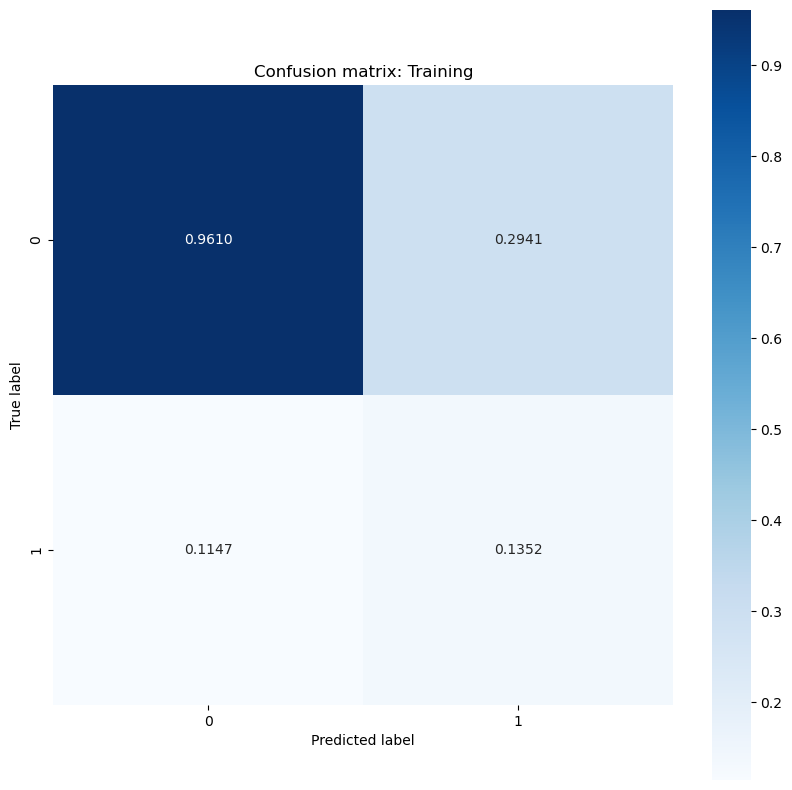

In [28]:
show_confusion_matrix(y_train, train_classes, 'Training')

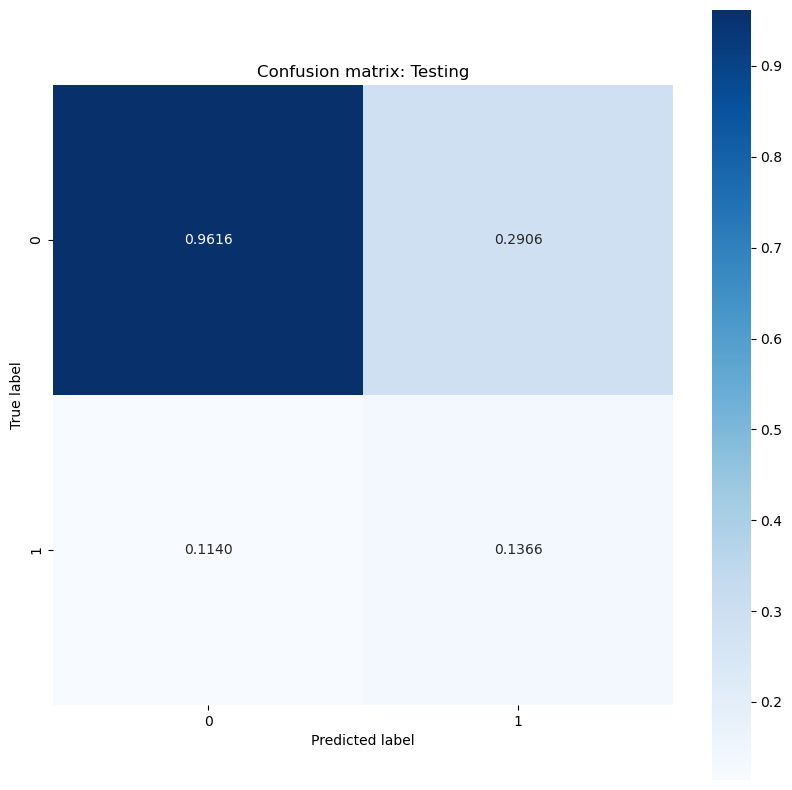

In [29]:
show_confusion_matrix(y_test, test_classes, 'Testing')

Observe the error rate measurements and interpret their significance in the context of this example. In many medical testing studies such as cancer detection, having a high false positive rate to ensure a low false negative rate is perfectly acceptable and in fact encouraged since the risk of missing a malignant tumor diagnosis (false negative) is a lot worse than misclassifying a benign tumor as malignant (false positive).

In order to control for the FPR and FNR, try changing the threshold hyperparameter before classifying the probability predictions. A lower threshold increases the model's overall chances of making a malignant tumor classification. This inevitably increases the number of false positives and the FPR but it also helps to decrease the number of false negatives and the FNR.

## Save the model

Start by making an export module that takes in raw data and performs the following operations:
- Normalization
- Probability prediction
- Class prediction


In [34]:
class ExportModule(tf.Module):
  def __init__(self, model, class_pred):
    # Initialize pre- and post-processing functions
    self.model = model
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
  def __call__(self, x):
    # Run the `ExportModule` for new data points
    y = self.model(x, train=False)
    y = self.class_pred(y)
    return y 

In [35]:
log_reg_export = ExportModule(model=log_reg,
                              class_pred=predict_class)

If you want to save the model at its current state, you can do so with the `tf.saved_model.save` function. To load a saved model and make predictions, use the `tf.saved_model.load` function.

In [38]:
models = tempfile.mkdtemp()
save_path = os.path.join('../models', 'log_reg_export')
tf.saved_model.save(log_reg_export, save_path)

INFO:tensorflow:Assets written to: ../models\log_reg_export\assets


In [39]:
log_reg_loaded = tf.saved_model.load(save_path)
test_preds = log_reg_loaded(x_test)
test_preds[:10].numpy()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Conclusion

This notebook introduced a few techniques to handle a logistic regression problem. Here are a few more tips that may help:

- The [TensorFlow Core APIs](https://www.tensorflow.org/guide/core) can be used to build machine learning workflows with high levels of configurability
- Analyzing error rates is a great way to gain more insight about a classification model's performance beyond its overall accuracy score.
- Overfitting is another common problem for logistic regression models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](../../tutorials/keras/overfit_and_underfit.ipynb) tutorial for more help with this.

For more examples of using the TensorFlow Core APIs, check out the [guide](https://www.tensorflow.org/guide/core). If you want to learn more about loading and preparing data, see the tutorials on [image data loading](../../load_data/images.ipynb) or [CSV data loading](../../load_data/csv.ipynb).